# **Homework 2**
# **SHAP**
# MIMUW XAI WINTER 2022/2023

# Task A

In this homework we used brain stroke dataset from kaggle.

### A1 
I prepared the data (onehot encoding) and
first trained XGBClassifier model.The model achieved 94,6% accuracy. 

### A2
I selected two random observations: indexes 7 and 26. Their both predictions was 0.

### A3

#### A3.1 shap
I calculated decomposition of predictions first usign shap library. The results are following:




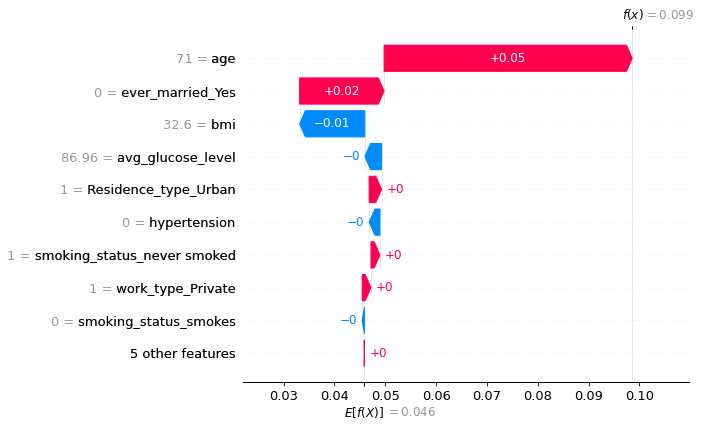

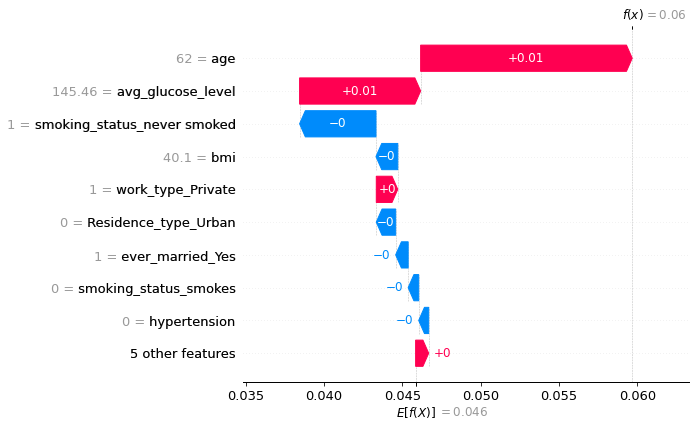

On the images we can osbserve that age the attribute which contributes the most in both cases is age.

#### A3.2 dalex
Next I calculated decomposition of predictions first usign dalex library. The results are following:

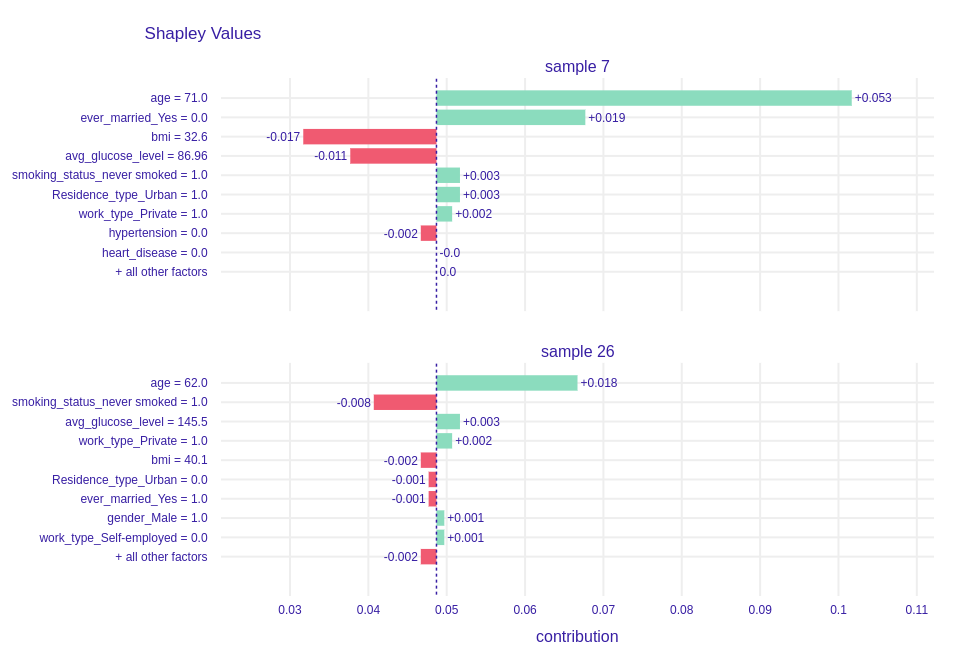

From dalex we can also see that age afects predicrtion the most in both samples.

### A4
I found that samples 8 and 2 have different highest attribution: *bmi* and *age*.

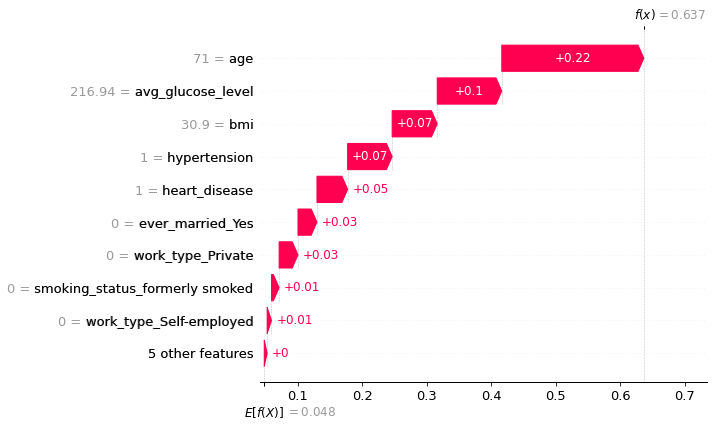

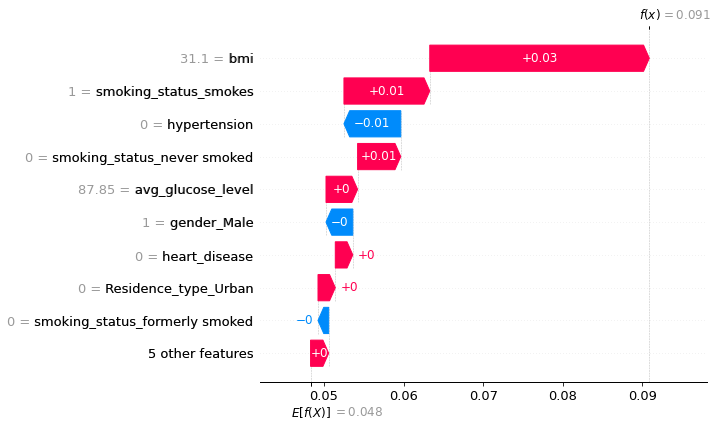

### A5 
I found that sample index 9 have negative value on age attribute.

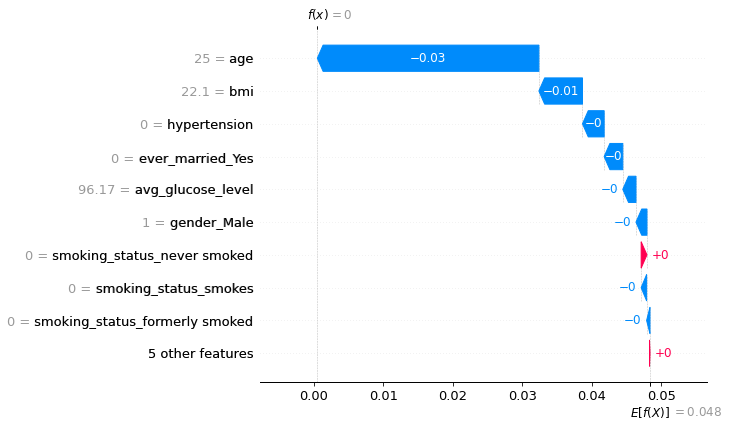

It makes sense, as this person is very young.

### A6
We can observe that highest attributions is the same (age) and values on less important attributes are very similar.

### A7

I trained model with the same data using CatBoostClassifier.

Decomposition result from *shap*:

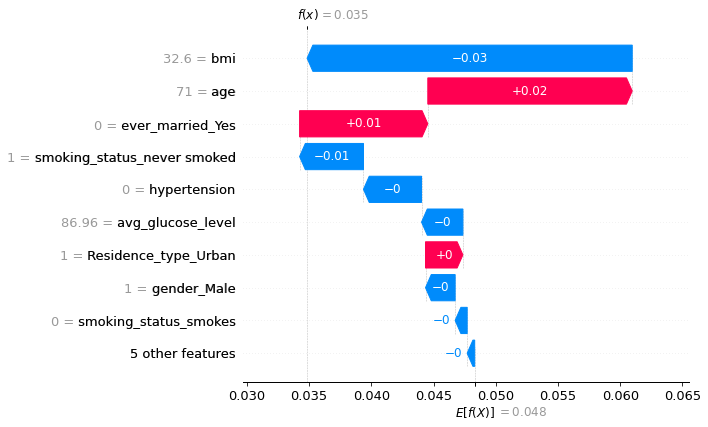

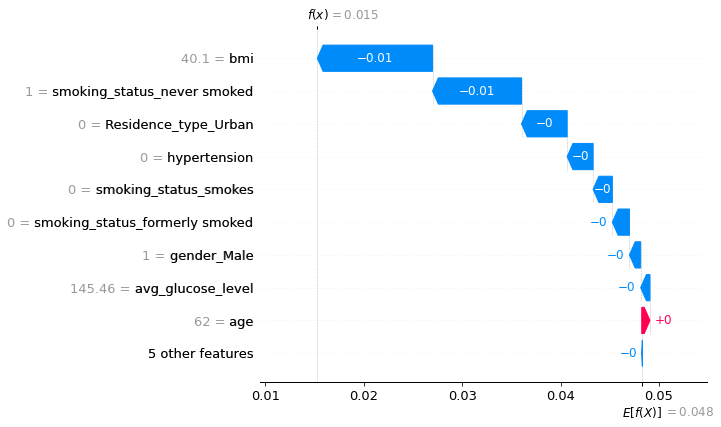

Suprisingly results looks completely different. Age in the second sample is not even in top5 of attributes.

### A8

Age attribute affects prediction the most in resutls from both dalex and shap libraries. This conclusion is consistent with intuition: the older you are the more health issues you have.

# Appendix

## 0. Setup

In [1]:
!pip install dalex shap catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

import dalex as dx
import shap

In [3]:
df = pd.read_csv("brain_stroke.csv")
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


Dataset consists of features that are nonnumerical. Let's  hot encode them first.

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


df_one_hot = pd.get_dummies(df, drop_first = True)
df_one_hot

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,1,1,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,1,1,1,0,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,1,1,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,1,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,41.0,0,0,70.15,29.8,0,1,0,1,0,0,0,1,0,0
4977,40.0,0,0,191.15,31.1,0,1,1,1,0,0,1,0,0,1
4978,45.0,1,0,95.02,31.8,0,0,1,0,0,0,0,0,0,1
4979,40.0,0,0,83.94,30.0,0,1,1,1,0,0,0,0,0,1


Preparing train and test samples.

In [35]:
X = df_one_hot.drop("stroke", axis=1)
y = df_one_hot.stroke
X_train, X_test, y_train, y_test =train_test_split( X, y, test_size=0.2, random_state=42)

In [36]:
X_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1652,26.00,0,0,168.15,22.9,0,0,1,0,0,1,0,1,0
1609,27.00,0,0,80.57,39.8,0,1,1,0,0,1,0,0,1
166,54.00,0,0,87.85,31.1,1,1,0,0,0,0,0,0,1
2488,2.00,0,0,92.30,14.8,0,0,0,0,1,0,0,0,0
3337,69.00,1,0,112.69,33.5,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,54.00,0,0,231.54,29.9,0,1,0,0,0,1,0,1,0
466,38.00,0,0,70.92,41.6,0,1,0,0,0,1,0,1,0
3092,13.00,0,0,90.60,16.9,1,0,1,0,0,0,0,1,0
3772,0.48,0,0,118.75,17.4,0,0,0,0,1,0,0,0,0


In [41]:
X_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1652,26.00,0,0,168.15,22.9,0,0,1,0,0,1,0,1,0
1609,27.00,0,0,80.57,39.8,0,1,1,0,0,1,0,0,1
166,54.00,0,0,87.85,31.1,1,1,0,0,0,0,0,0,1
2488,2.00,0,0,92.30,14.8,0,0,0,0,1,0,0,0,0
3337,69.00,1,0,112.69,33.5,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,54.00,0,0,231.54,29.9,0,1,0,0,0,1,0,1,0
466,38.00,0,0,70.92,41.6,0,1,0,0,0,1,0,1,0
3092,13.00,0,0,90.60,16.9,1,0,1,0,0,0,0,1,0
3772,0.48,0,0,118.75,17.4,0,0,0,0,1,0,0,0,0


## 1. Training XGBoost classifier model

In [7]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
xgb_predict=xgb.predict(X_test)
xgb_acc=accuracy_score(xgb_predict,y_test)
model = xgb
xgb_acc

0.9458375125376128

The model achieved 94,6% accuracy.

## 2. Selecting two observations and calculating model's prediction

In [8]:
observations = [7,26]
predictions = model.predict(X_train.iloc[observations])
predictions

array([0, 0])

## 3. Calculating the decomposition of predictions

### 3.1 shap

In [9]:
shap_explainer = shap.explainers.Tree(model, data=X_train, model_output="probability")

In [10]:
shap_values = shap_explainer(X_train)
shap_values

.values =
array([[-4.25091854e-02, -2.51643401e-04, -3.04295144e-05, ...,
        -8.08366200e-05, -6.94827965e-04, -2.57151516e-04],
       [-3.95211450e-02, -2.80121445e-04, -2.54839343e-05, ...,
        -1.70781092e-05,  3.10111832e-04,  1.65502943e-03],
       [-6.28128845e-03, -1.95059212e-03, -6.08448822e-05, ...,
        -6.92792683e-05,  2.10724160e-03,  2.76480605e-03],
       ...,
       [-3.96301980e-02, -3.16560712e-04, -1.56709182e-05, ...,
        -7.69859217e-05, -3.43933513e-04, -2.43593022e-04],
       [-4.13449077e-02, -3.07127952e-04, -3.70758166e-05, ...,
        -7.94013712e-05,  5.64832985e-04, -2.52082456e-04],
       [ 1.41939913e-02, -7.83813856e-04, -1.87863600e-04, ...,
        -3.25774793e-05, -6.95503819e-03, -5.55084752e-04]])

.base_values =
array([0.04584684, 0.04584684, 0.04584684, ..., 0.04584684, 0.04584684,
       0.04584684])

.data =
array([[26.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [27.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
    

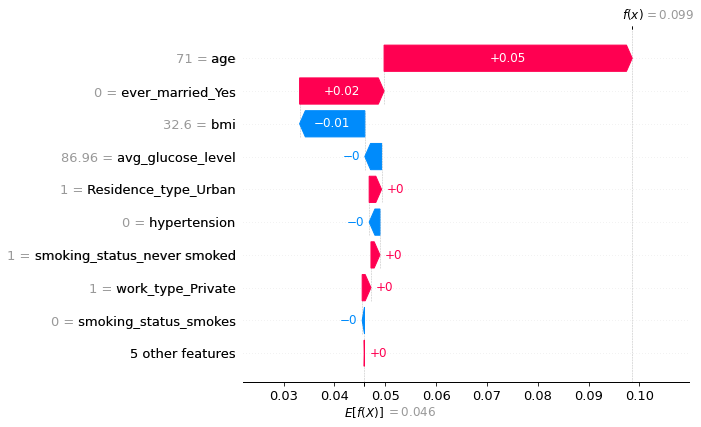

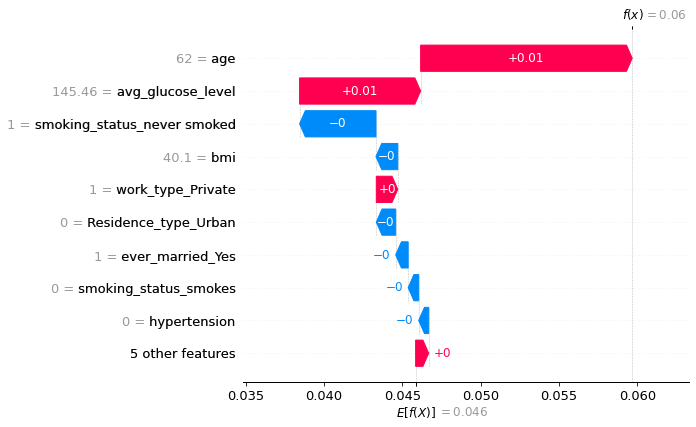

In [11]:
for i in observations:
    shap.plots.waterfall(shap_values[i])

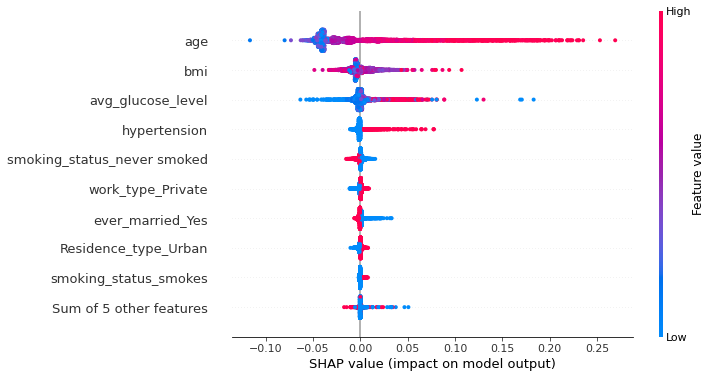

In [12]:
shap.plots.beeswarm(shap_values, max_display=10, plot_size=(9, 6))

Quite interesting, high and low age clearly affects prediction, but affect of bmi high/low values are not so clear.

### 3.2 dalex

In [13]:
model_predicting_method = lambda m, d: m.predict_proba(d)[:, 1]

explainer = dx.Explainer(model, X_train, y_train, predict_function=model_predicting_method, label="brain_stroke")

Preparation of a new explainer is initiated

  -> data              : 3984 rows 14 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3984 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : brain_stroke
  -> predict function  : <function <lambda> at 0x7f56ae0d5b90> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000722, mean = 0.0487, max = 0.481
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.349, mean = 4.35e-06, max = 0.986
  -> model_info        : package xgboost

A new explainer has been created!


In [14]:
explainer.model_performance()

invalid value encountered in long_scalars


,recall,precision,f1,accuracy,auc
brain_stroke,0.0,NaN,NaN,0.951305,0.913604


In [15]:
def pf_xgboost_classifier_categorical(model, df):
    df.loc[:, df.dtypes == 'object'] =\
        df.select_dtypes(['object'])\
        .apply(lambda x: x.astype('category'))
    return model.predict_proba(df)[:, 1]

explainer = dx.Explainer(model, X_train, y_train, predict_function=pf_xgboost_classifier_categorical, label="brain_stroke")

Preparation of a new explainer is initiated

  -> data              : 3984 rows 14 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3984 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : brain_stroke
  -> predict function  : <function pf_xgboost_classifier_categorical at 0x7f56ae077a70> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000722, mean = 0.0487, max = 0.481
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.349, mean = 4.35e-06, max = 0.986
  -> model_info        : package xgboost

A new explainer has been created!


In [16]:
explainer.predict(X_train.iloc[observations])

array([0.09858399, 0.05967139], dtype=float32)

In [17]:
shap_attributions = [explainer.predict_parts(X_train.iloc[[i]], type="shap", label=f'sample {i}') for i in observations]

In [18]:
shap_attributions[0].plot(shap_attributions[1::])

In [19]:
bd_attributions = [explainer.predict_parts(X_train.iloc[[i]], type="break_down", label=f'sample {i}') for i in observations]

In [20]:
bd_attributions[0].plot(bd_attributions[1::])

## 4. Looking for different variables of highest importance

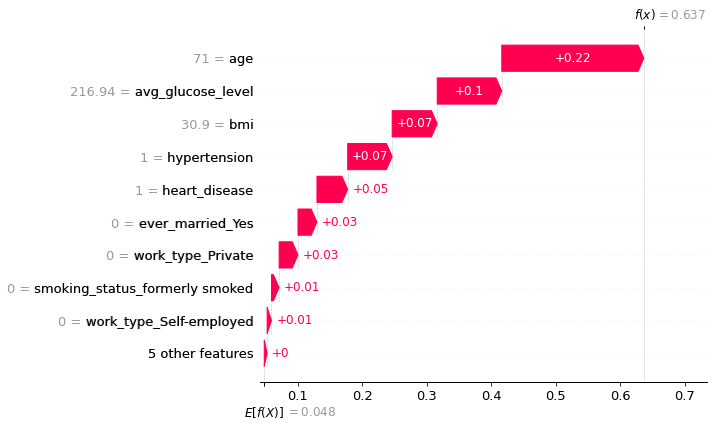

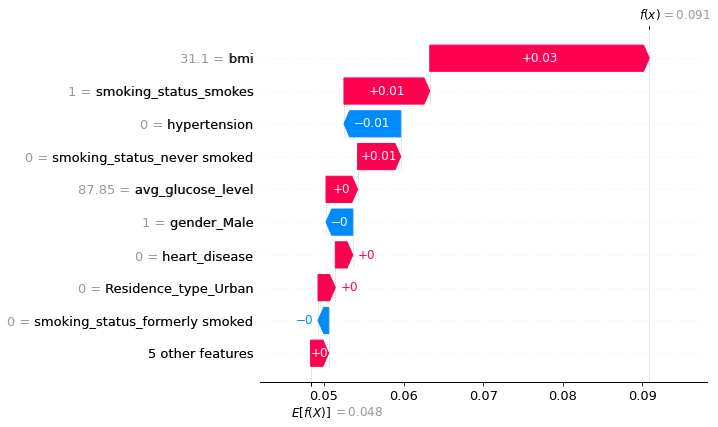

In [29]:
shap.plots.waterfall(shap_values[9])
shap.plots.waterfall(shap_values[2])

On the first sample hightest importance is *remainder_bmi* and on a second one it is *remainder_age*.

## 5. Looking for opposite attribution

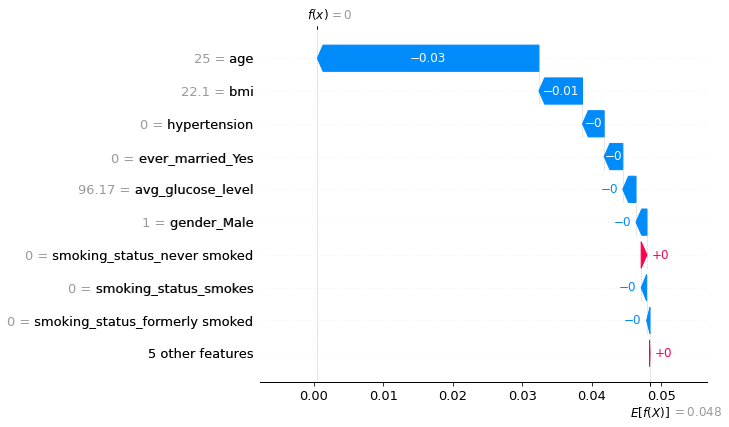

In [28]:
shap.plots.waterfall(shap_values[8])

Previous samples had positive attribution on *remainder_age*.

## 6. Comparing shap and dalex result

We can observe that dalex and shap returns different highest importance attribute.

## 7. Trying with different model

In [61]:
from catboost import CatBoostClassifier
cat=CatBoostClassifier()
cat.fit(X_train,y_train)
cat_predict=xgb.predict(X_test)
cat_acc=accuracy_score(xgb_predict,y_test)
model = cat
cat_acc

Learning rate set to 0.01859
0:	learn: 0.6625007	total: 15.8ms	remaining: 15.8s
1:	learn: 0.6367922	total: 23.3ms	remaining: 11.6s
2:	learn: 0.6078206	total: 31.2ms	remaining: 10.4s
3:	learn: 0.5863003	total: 49.7ms	remaining: 12.4s
4:	learn: 0.5589733	total: 55.1ms	remaining: 11s
5:	learn: 0.5365744	total: 62.5ms	remaining: 10.3s
6:	learn: 0.5161206	total: 71.9ms	remaining: 10.2s
7:	learn: 0.4957057	total: 76.4ms	remaining: 9.47s
8:	learn: 0.4767107	total: 82.7ms	remaining: 9.11s
9:	learn: 0.4575059	total: 85.3ms	remaining: 8.44s
10:	learn: 0.4422810	total: 87.8ms	remaining: 7.9s
11:	learn: 0.4290176	total: 90.4ms	remaining: 7.44s
12:	learn: 0.4145891	total: 92ms	remaining: 6.99s
13:	learn: 0.4024026	total: 94.8ms	remaining: 6.68s
14:	learn: 0.3908652	total: 97.8ms	remaining: 6.42s
15:	learn: 0.3791506	total: 101ms	remaining: 6.2s
16:	learn: 0.3675902	total: 104ms	remaining: 6s
17:	learn: 0.3581757	total: 107ms	remaining: 5.82s
18:	learn: 0.3458075	total: 110ms	remaining: 5.66s
19:	le

0.9458375125376128

In [50]:
shap_explainer = shap.explainers.Tree(model, data=X_train, model_output="probability")

In [51]:
shap_values = shap_explainer(X_train)
shap_values

100%|===================| 3973/3984 [04:04<00:00]       

.values =
array([[-2.96703334e-02, -3.04637475e-03,  1.35093621e-04, ...,
        -8.31912844e-04, -1.37742342e-03, -1.32038098e-03],
       [-2.95784587e-02, -3.30550269e-03,  1.27560025e-04, ...,
        -1.00778071e-03,  2.14881113e-04,  1.95820640e-03],
       [-2.81874132e-04, -7.13918694e-03,  2.19878593e-03, ...,
        -1.34189708e-03,  5.42400009e-03,  1.07844019e-02],
       ...,
       [-2.99742962e-02, -2.76782961e-03,  9.06552984e-05, ...,
        -9.90685570e-04, -1.17664730e-03, -1.06688175e-03],
       [-2.60523489e-02, -3.19113001e-03, -7.64614916e-05, ...,
        -1.28984393e-03,  9.69363981e-05, -1.27986316e-03],
       [ 4.36875534e-03, -4.43542273e-03,  1.06031283e-03, ...,
        -5.74287493e-04, -7.79374443e-03, -2.46067569e-03]])

.base_values =
array([0.04830529, 0.04830529, 0.04830529, ..., 0.04830529, 0.04830529,
       0.04830529])

.data =
array([[26.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [27.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
    

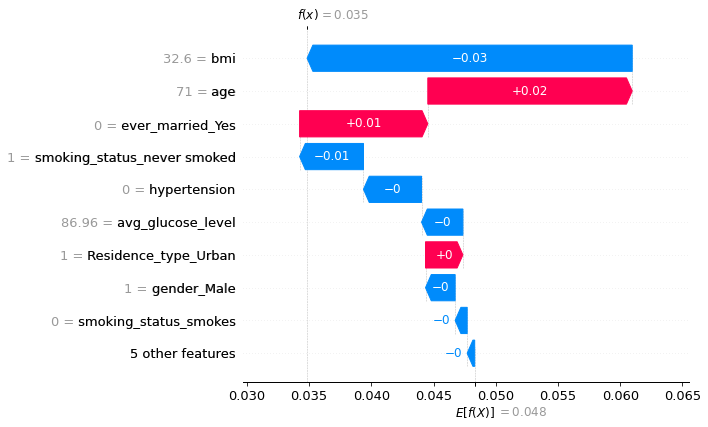

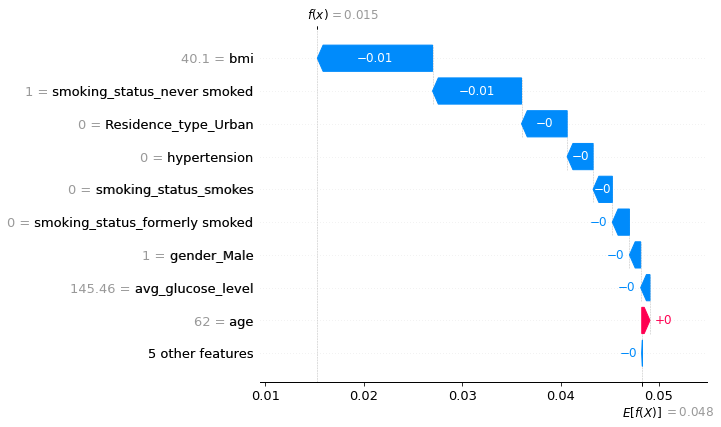

In [60]:
for i in observations:
    shap.plots.waterfall(shap_values[i])

# Task B

Given v function:
v() = 0
v(A) = 20
v(B) = 20
v(C) = 60
v(A,B) = 60
v(A,C) = 70
v(B,C) = 70
v(A,B,C) = 100

We have 6 permutations of ABC:
ABC,
ACB,
BAC,
BCA,
CAB,
CBA.

Let's check how adding A player changes value of coalition:\
v(A) - V({}) = 20 \
v(A,B) - V(B) = 40 \
v(A,C) - V(C) = 10 \
v(A,B,C) - V(B,C) = 30 \

Counting an average of difference of permutations: 

$\phi_A $ = 1 / 6 * (20 + 20 + 40 + 30 + 10 + 30) = 150/6 = 25

